In [1]:
conda install quandl

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



## Package Plan ##

  environment location: /Users/sarahedens/anaconda3

  added / updated specs:
    - quandl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.3.11  |       hca03da5_0         128 KB
    certifi-2024.2.2           |  py311hca03da5_0         161 KB
    openssl-3.0.13             |       h1a28f6b_2         4.3 MB
    quandl-3.6.1               |  py311hca03da5_0          66 KB
    ------------------------------------------------------------
                                           Total:         4.6 MB


# 1. Import libraries and data

In [38]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [39]:
import quandl

# Set your Quandl API key
quandl.ApiConfig.api_key = 'PQyQtZ_c5VpC1JDNdopD'

## Overview of data: 

The Zillow Real Estate Data (ZILLOW) data feed contains real estate market indicators, such as market indices, rental, sales, and inventories for thousands of geographical areas across the United States.

In [27]:
data = quandl.get_table('ZILLOW/DATA',indicator_id='ZSFH', region_id='99999')

In [17]:
data.head(5)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-04-30,471998.338021
1,ZSFH,99999,2024-03-31,470671.863494
2,ZSFH,99999,2024-02-29,471144.364833
3,ZSFH,99999,2024-01-31,474834.034632
4,ZSFH,99999,2023-12-31,478670.136789


In [18]:
data.shape

(232, 4)

In [19]:
type(data)

pandas.core.frame.DataFrame

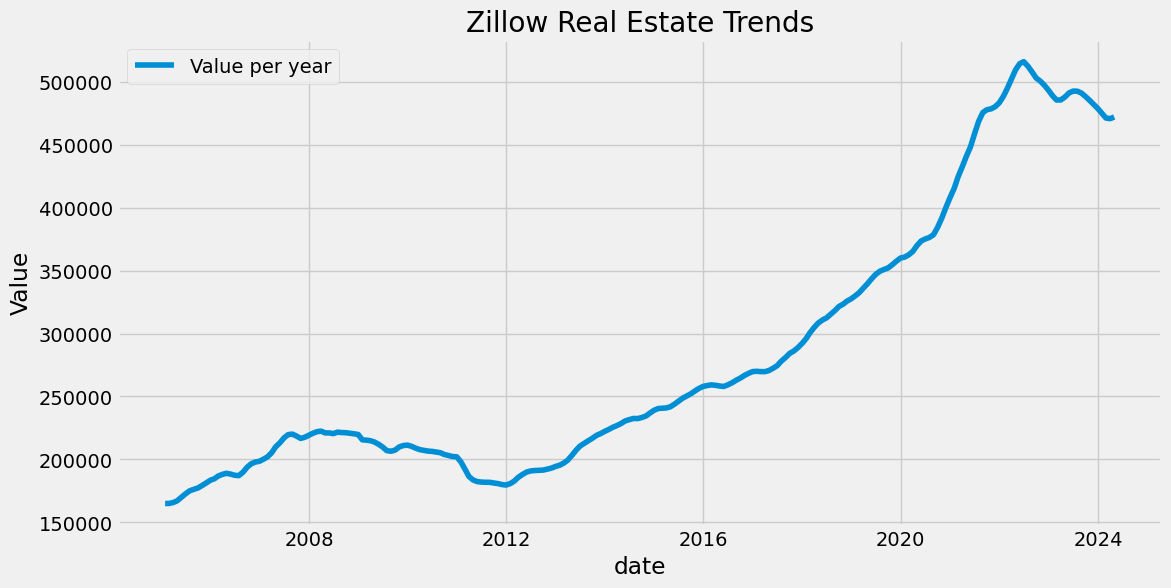

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Value per year')
plt.title('Zillow Real Estate Trends')
plt.xlabel('date')
plt.ylabel('Value')
plt.legend()
plt.show()


# 2. Subsetting, wrangling, and clean time-series data

#### I did not need to create a subset because these dates were perfect for the alignment of my OG dataset, we can use the one above. 

# 3. Time series analysis: Decomposition

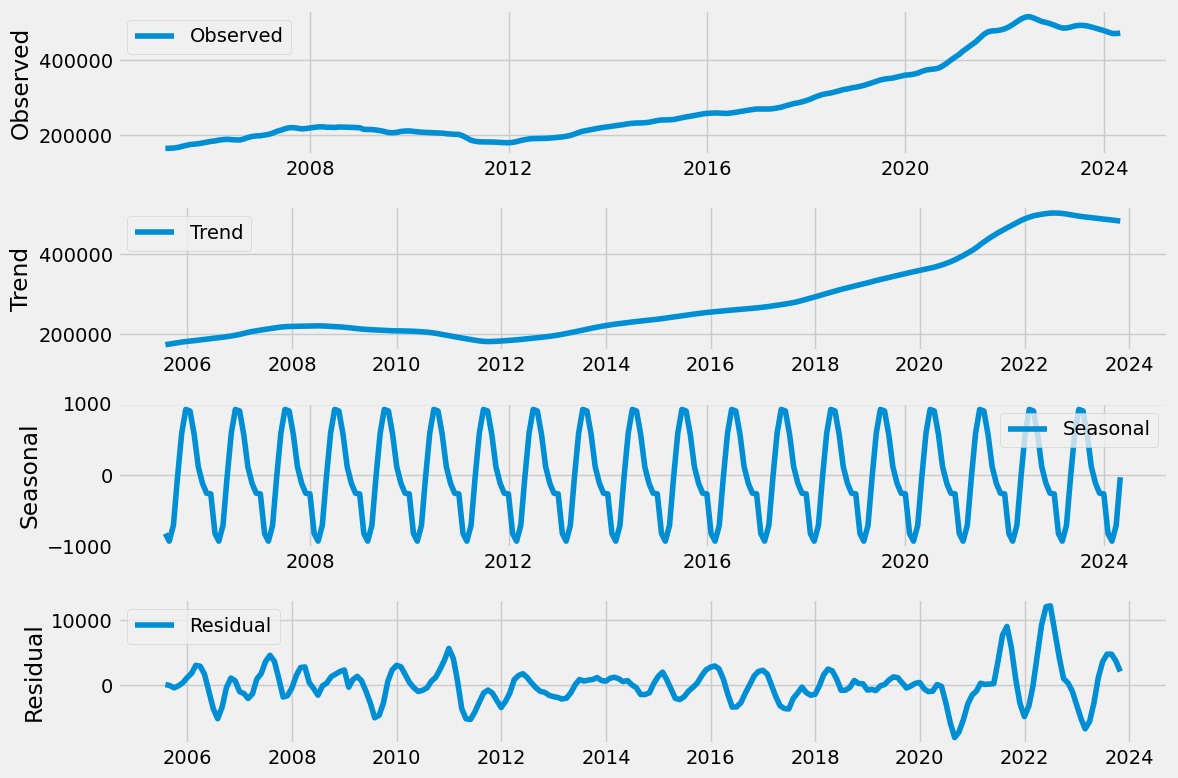

In [42]:
# import statsmodels.api as sm

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(data['value'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(data.index, decomposition.observed, label='Observed')
plt.legend()
plt.ylabel('Observed')

plt.subplot(4, 1, 2)
plt.plot(data.index, decomposition.trend, label='Trend')
plt.legend()
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(data.index, decomposition.seasonal, label='Seasonal')
plt.legend()
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(data.index, decomposition.resid, label='Residual')
plt.legend()
plt.ylabel('Residual')

plt.tight_layout()
plt.show()


Observed Trend: Shows a consistent upward trend, indicating overall property value growth over time.

Trend: Also increasing, with a notable acceleration from 2014 to 2022, suggesting a faster rate of value appreciation during this period.

Seasonal: Reflects periodic patterns, likely influenced by seasonal variations in demand, weather, or cultural factors.

Residual (or Noise): Experienced a significant drop around 2011 and a subsequent increase before 2012, indicating deviations from expected trends, possibly due to external events. A sharp increase in 2022 followed by a drop indicates periods of unusual market behavior requiring further investigation.

# 4. Dickey-Fuller Test

In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(data['value'])

# Extract and print test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')


ADF Statistic: -2.497505777076393
p-value: 0.11608237622524259
Critical Values:
	1%: -3.459884913337196
	5%: -2.8745310704320794
	10%: -2.573693840082908


The p-value, which tells us whether the data is stationary or not, is 0.1161. In statistical terms, this value is higher than the commonly used threshold of 0.05. So, we can't confidently say that the data is stationary.

Looking at the critical values:

At the 1% level, the critical value is -3.4599.
At the 5% level, it's -2.8745.
And at the 10% level, it's -2.5737.
The ADF statistic we obtained (-2.4975) is higher than all these critical values.

The data likely has some patterns or trends that make it non-stationary. This means it might not be suitable for certain types of analyses or forecasts without further adjustments or transformations.

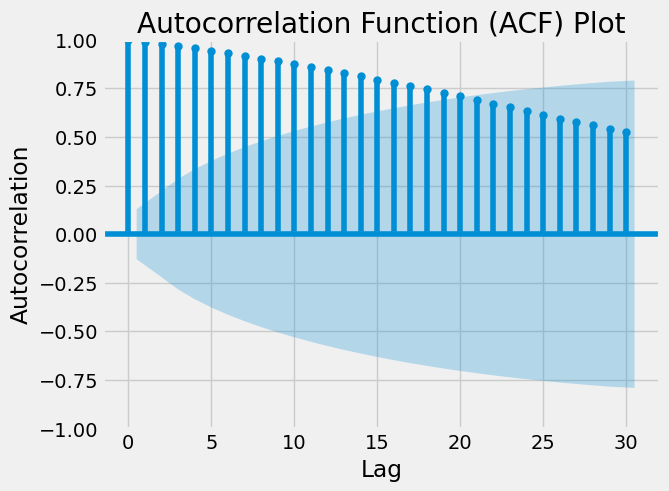

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelations
plot_acf(data['value'], lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()


### This visualizaiton shows that there is a weak or no correlation between the observations at different lags

In [45]:
# Take first-order difference
differenced_data = data['value'].diff().dropna()

# Perform Augmented Dickey-Fuller test on differenced data
result_diff = adfuller(differenced_data)

# Print test results
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])
print('Critical Values after differencing:')
for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')


ADF Statistic after differencing: -3.1309527285129692
p-value after differencing: 0.024345744106542926
Critical Values after differencing:
	1%: -3.459884913337196
	5%: -2.8745310704320794
	10%: -2.573693840082908


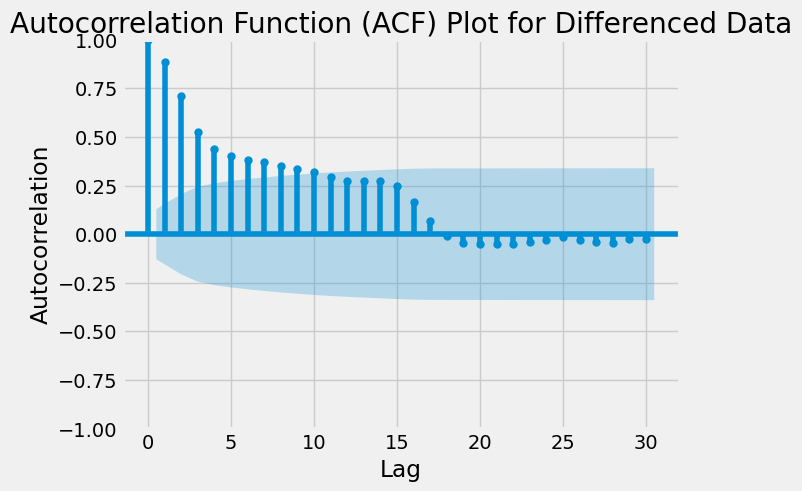

In [46]:
# Plot autocorrelations for differenced data
plot_acf(differenced_data, lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot for Differenced Data')
plt.show()


### The negative autocorrelation values below the 0.00 line after around 16 lags suggest a reversal in the direction of correlation beyond that point, where high values tend to be followed by low values, and vice versa.


#### ADF Test: The ADF statistic after differencing (-3.13095) resulted in a p-value (0.02435) below the significance level of 0.05. This indicates that we can reject the null hypothesis of the ADF test, suggesting that the differenced data is likely stationary.

#### ACF Plot: The autocorrelation function (ACF) plot for the differenced data showed a decay in autocorrelation values as the lag increased, with some negative autocorrelation values below the 0.00 line after around 16 lags. This pattern shows stationary data.